<a href="https://colab.research.google.com/github/prog815/abscur/blob/master/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D0%B7%D0%BD%D0%B0%D0%BA%D0%B0_%D0%B0%D0%B1%D1%81%D0%BE%D0%BB%D1%8E%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BA%D1%83%D1%80%D1%81%D0%B0_%D0%B2%D0%B0%D0%BB%D1%8E%D1%82_%D0%BD%D0%B0_%D0%B7%D0%B0%D0%B2%D1%82%D1%80%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем библиотеки

In [1]:
! pip install git+https://github.com/prog815/abscur

  Cloning https://github.com/prog815/abscur to /tmp/pip-req-build-e5cmpc5i
  Running command git clone -q https://github.com/prog815/abscur /tmp/pip-req-build-e5cmpc5i
  Created wheel for abscur: filename=abscur-0.1.29-py3-none-any.whl size=10613 sha256=33b50dd9dd3cf4b6332e815b5340c8f6f9b52b700e5e348d7a5113c224984e7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-x3i50f_w/wheels/86/f5/5a/f7cc6c106e525a45251b8a6391d536b7342b2c354e5b28fb7c
Successfully built abscur


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import abscur

# Загрузка котировок

In [3]:
data = abscur.get_abs_curses()

In [4]:
data.shape

(1000, 45)

In [5]:
d_data = data.pct_change()

# Подготовка данных

## Выход

In [6]:
# outDataHigh = (all_data['High'] / all_data['Close'].shift(1)).values
# outDataLow = (all_data['Low'] / all_data['Close'].shift(1)).values
output = np.array((d_data > 0) * 1)
output.shape

(1000, 45)

## Первый вход - окно (без сдвига)

In [7]:
WINDOW = 10
# d = pd.DataFrame(inpData1)
# inpData1 = np.hstack([d.shift(n).values for n in range(WINDOW)])
# inpData1.shape
inpData1 = np.ones((d_data.shape[0],WINDOW,d_data.shape[-1]))
d = d_data.copy()
for n in range(WINDOW):
    inpData1[:,n,:] = d.shift(n).values
inpData1.shape

(1000, 10, 45)

## Второй вход - даты (без сдвига)

In [8]:
days = d_data.index.day.values
weekdays = d_data.index.weekday.values
months = d_data.index.month.values
x2sc = lambda x,per: np.transpose([np.sin(x/per*2*np.pi),np.cos(x/per*2*np.pi)])
inpData2 = np.hstack([x2sc(days,31),x2sc(weekdays,7),x2sc(months,12)])
inpData2.shape

(1000, 6)

## Разделяем обучение и расчет (появляется сдвиг)

In [14]:
inpData1Calc = inpData1[-1,...]

inpData1Learn = inpData1.copy()
inpData1Learn[1:,...] = inpData1Learn[:-1,...]

inpData2Calc = inpData2[-1,...]

inpData2Learn = inpData2.copy()
inpData2Learn[1:,...] = inpData2Learn[:-1,...]

[v.shape for v in (inpData1Learn,inpData2Learn,inpData1Calc,inpData2Calc,output)]

[(1000, 10, 45), (1000, 6), (10, 45), (6,), (1000, 45)]

## Чистим пустоты на обучении

In [15]:
index = (~np.isnan(np.sum(inpData1Learn,axis=(1,2)))) & (~np.isnan(np.sum(inpData2Learn,axis=1))) & (~np.isnan(np.sum(output,axis=1)))
np.unique(index,return_counts=True)

(array([False,  True]), array([ 11, 989]))

In [16]:
inpData1Learn = inpData1Learn[index,:]
inpData2Learn = inpData2Learn[index,:]
output = output[index,:]
learnDates = d_data.index.values[index]

In [17]:
print('inpData1Learn size',inpData1Learn.shape)
print('inpData2Learn size',inpData2Learn.shape)
print('output size',output.shape)
print('Learn dates from',learnDates[0],'to',learnDates[-1])

inpData1Learn size (989, 10, 45)
inpData2Learn size (989, 6)
output size (989, 45)
Learn dates from 2017-11-21T00:00:00.000000000 to 2021-09-03T00:00:00.000000000


## Разделение на обучение и тест

In [18]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test, d_train, d_test = train_test_split(inpData1Learn,inpData2Learn,output,learnDates,test_size=0.33,shuffle=False)

## Нормировка данных (слой нормировки первого входа)

In [19]:
normLayer = keras.layers.experimental.preprocessing.Normalization(axis=-1)
normLayer.adapt(X1_train)

# Модель

## Функция создания

In [39]:
def build_model(hp=None):
    input1 = keras.layers.Input(shape=X1_train.shape[1:])
    x1 = normLayer(input1)

    if hp is None:
        units = 30
        kernel = 3
    else:
        units = hp.Choice('units',range(10,100))
        kernel = hp.Choice('kernel',range(2,5+1))

    x1 = keras.layers.Conv1D(units,
                             kernel,
                             padding='same',
                             activation='relu')(x1)

    x1 = keras.layers.Flatten()(x1)

    input2 = keras.layers.Input(shape=(X2_train.shape[1],))

    x = keras.layers.Concatenate()([x1,input2])

    output = keras.layers.Dense(1)(x)

    model = keras.Model((input1,input2),output)
    model.compile(optimizer=tf.optimizers.Adam(),
                loss=tf.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    # model.summary()
    return model

build_model()

взяли изначально жесткие параметры

## Обучение

In [42]:
pn = 'RandomSearch'
dir = '/tmp/tboard_logs/' + pn


res = []

for n in range(y_train.shape[1]):

    cb = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=100,restore_best_weights=True,verbose=False),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',patience=50,verbose=False)]

    model = build_model()

    model.fit((X1_train,X2_train),y_train[:,n],
            epochs=1000,
            validation_split=0.3,
            verbose=False,
            callbacks = cb)
    
    train_kach = model.evaluate([X1_train,X2_train],y_train[:,n],verbose=0)[1]
    test_kach = model.evaluate([X1_test,X2_test],y_test[:,n],verbose=0)[1]

    r = {'name':data.columns[n],'train_kach':train_kach,'test_kach':test_kach,'model':model}

    res.append(r)

    print(r)

    # break

{'name': 'AUD', 'train_kach': 0.6782477498054504, 'test_kach': 0.5290519595146179, 'model': <keras.engine.functional.Functional object at 0x7f0a4b2d8890>}
{'name': 'CAD', 'train_kach': 0.8670694828033447, 'test_kach': 0.5443425178527832, 'model': <keras.engine.functional.Functional object at 0x7f0a4b075690>}
{'name': 'HKD', 'train_kach': 0.596676766872406, 'test_kach': 0.5443425178527832, 'model': <keras.engine.functional.Functional object at 0x7f0a4af105d0>}
{'name': 'JPY', 'train_kach': 0.8323262929916382, 'test_kach': 0.5137614607810974, 'model': <keras.engine.functional.Functional object at 0x7f0a4af4ab90>}
{'name': 'SEK', 'train_kach': 0.8746223449707031, 'test_kach': 0.5137614607810974, 'model': <keras.engine.functional.Functional object at 0x7f0aa8ac3690>}
{'name': 'USD', 'train_kach': 0.5543806552886963, 'test_kach': 0.5229358077049255, 'model': <keras.engine.functional.Functional object at 0x7f0aa9336f50>}
{'name': 'CHF', 'train_kach': 0.5241692066192627, 'test_kach': 0.483180

Обучили и протестировали модели для всех выходов

## Суммарно отчет по качеству каждой модели

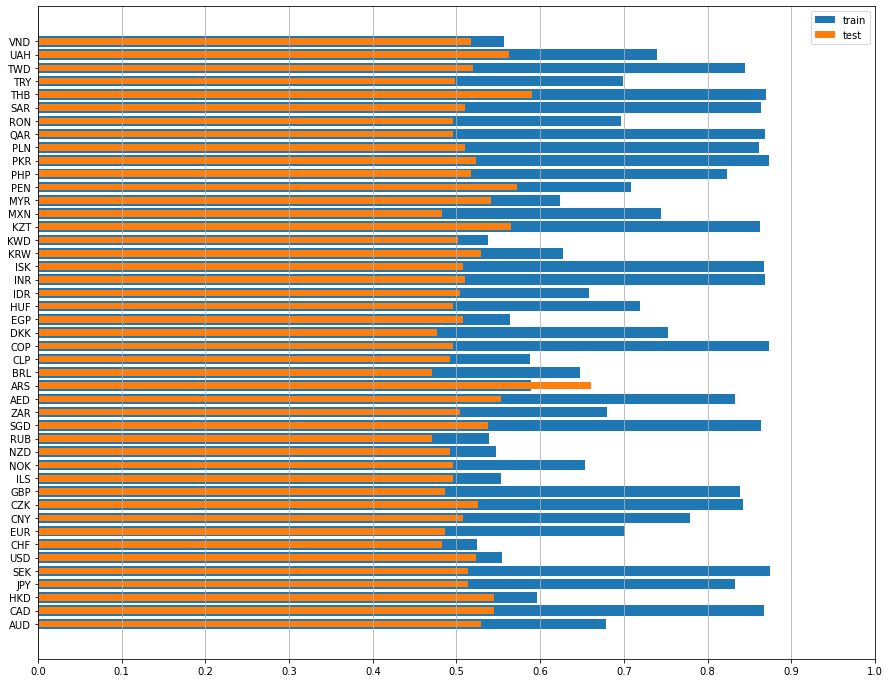

In [60]:
names_list = [r['name'] for r in res]
train_kach_list = [r['train_kach'] for r in res]
test_kach_list = [r['test_kach'] for r in res]

plt.figure(figsize=(15,12))
plt.barh(names_list,train_kach_list,label='train')
plt.barh(names_list,test_kach_list,height=0.5,label='test')
plt.xticks(np.linspace(0,1,11))
plt.grid(axis='x')
plt.legend()
plt.show()

качество на тренировочной выборке (обучение+валидация) от 53% до 85%

качество на тестовой выборке 47% до 66%

## Схема модели

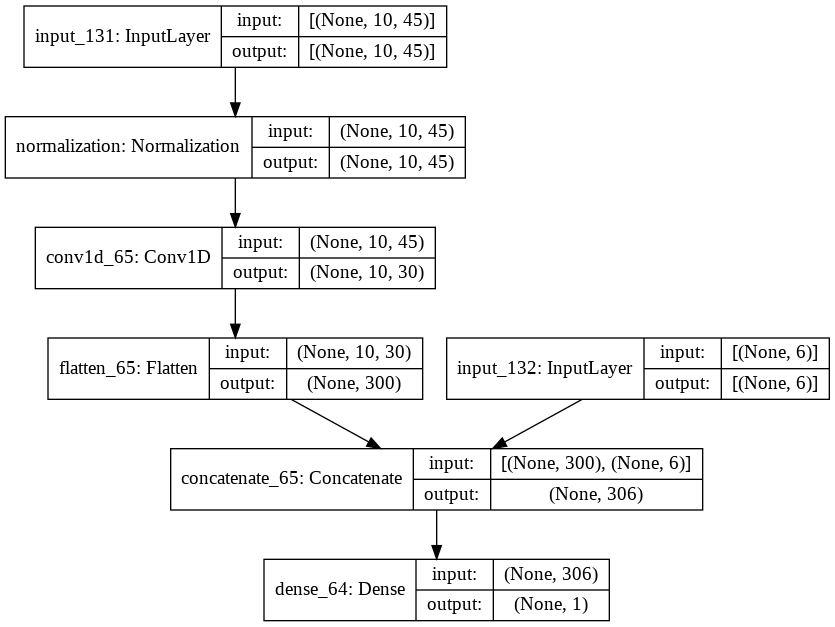

In [61]:
keras.utils.plot_model(model,show_shapes=True)